In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

In [ ]:
# resplit data into 70, 15, 15
import os
FILE_DIR = './chest_xray'
os.makedirs(os.path.join(FILE_DIR, 'NORMAL'), exist_ok=True)
os.makedirs(os.path.join(FILE_DIR, 'VIRAL'), exist_ok=True)
os.makedirs(os.path.join(FILE_DIR, 'BACTERIAL'), exist_ok=True)
parts = ['train', 'val', 'test']
for image in os.listdir(os.path.join(FILE_DIR, 'train', 'NORMAL')):
    os.rename(os.path.join(FILE_DIR, 'train', 'NORMAL', image), os.path.join(FILE_DIR, 'NORMAL', image))
for image in os.listdir(os.path.join(FILE_DIR, 'train', 'PNEUMONIA')):
    if 'virus' in image:
        os.rename(os.path.join(FILE_DIR, 'train', 'PNEUMONIA', image), os.path.join(FILE_DIR, 'VIRAL', image))
    else:
        os.rename(os.path.join(FILE_DIR, 'train', 'PNEUMONIA', image), os.path.join(FILE_DIR, 'BACTERIAL', image))

In [ ]:
import random
parts = ['train', 'val', 'test']
splits = ['NORMAL', 'VIRAL', 'BACTERIAL']
for part in parts:
    for split in splits:
        os.makedirs(os.path.join(FILE_DIR, part, split), exist_ok=True) 
for split in splits:
    images = os.listdir(os.path.join(FILE_DIR, split))
    #shuffle
    random.shuffle(images)
    n = len(images)
    for i, image in enumerate(images):
        if i < 0.7 * n:
            os.rename(os.path.join(FILE_DIR, split, image), os.path.join(FILE_DIR, 'train', split, image))
        elif i < 0.85 * n:
            os.rename(os.path.join(FILE_DIR, split, image), os.path.join(FILE_DIR, 'val', split, image))
        else:
            os.rename(os.path.join(FILE_DIR, split, image), os.path.join(FILE_DIR, 'test', split, image))

In [ ]:
import os
parts = ['train', 'val', 'test']
FILE_DIR = './chest_xray'
for part in parts:
    print(f"Number of viral images in {part}: {len(os.listdir(os.path.join(FILE_DIR, part, 'VIRAL')))}")
    print(f"Number of bacterial images in {part}: {len(os.listdir(os.path.join(FILE_DIR, part, 'BACTERIAL')))}")
    print(f"Number of normal images in {part}: {len(os.listdir(os.path.join(FILE_DIR, part, 'NORMAL')))}")

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4823], std=[0.2216])
])

train_ds = datasets.ImageFolder("chest_xray/train", transform=transform)
val_ds = datasets.ImageFolder("chest_xray/val", transform=transform)
test_ds = datasets.ImageFolder("chest_xray/test", transform=transform)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=True, num_workers=4)


In [2]:
import torch
from torch import nn

class BasicBlock(nn.Module):
    expansion = 1  # used in ResNet-50/101, not needed here but kept for generality

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample  # 1x1 conv if needed
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)  # match shapes

        out += identity
        out = self.relu(out)

        return out
class ResNet18(nn.Module):
    def __init__(self, num_classes=3, dropout_p=0.5):
        super(ResNet18, self).__init__()
        self.in_channels = 64

        # First conv
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual layers
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        # Head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout_p)
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = [BasicBlock(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)   # <-- added dropout here
        x = self.fc(x)

        return x


In [3]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=25):
    best_val_acc = 0.0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        loop = tqdm(train_loader, leave=False)  # only show training bar
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loop.set_postfix(loss=loss.item(), acc=correct/total)

        # Epoch summary
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation (done silently, no bar)
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Replace progress bar with final epoch stats
        loop.close()
        print(f"Epoch [{epoch+1}/{num_epochs}] "
            f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")

    # Visualization
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    print("Training complete.")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")


In [4]:
model = ResNet18(num_classes=3)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
from torchsummary import summary
summary(model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Epoch [1/25] Train Loss: 0.6404, Train Acc: 0.7212, Val Loss: 0.5691, Val Acc: 0.7395


Epoch [2/25] Train Loss: 0.4782, Train Acc: 0.7924, Val Loss: 0.5977, Val Acc: 0.7420


Epoch [3/25] Train Loss: 0.3997, Train Acc: 0.8313, Val Loss: 0.5436, Val Acc: 0.7573


Epoch [4/25] Train Loss: 0.3260, Train Acc: 0.8579, Val Loss: 0.6052, Val Acc: 0.7433


Epoch [5/25] Train Loss: 0.2027, Train Acc: 0.9143, Val Loss: 1.6001, Val Acc: 0.6271


Epoch [6/25] Train Loss: 0.1537, Train Acc: 0.9439, Val Loss: 0.8111, Val Acc: 0.7254


Epoch [7/25] Train Loss: 0.1696, Train Acc: 0.9335, Val Loss: 0.9927, Val Acc: 0.7088


Epoch [8/25] Train Loss: 0.1005, Train Acc: 0.9630, Val Loss: 1.0527, Val Acc: 0.6820


Epoch [9/25] Train Loss: 0.0337, Train Acc: 0.9899, Val Loss: 1.0326, Val Acc: 0.7318


Epoch [10/25] Train Loss: 0.0680, Train Acc: 0.9765, Val Loss: 1.0557, Val Acc: 0.7190


Epoch [11/25] Train Loss: 0.0696, Train Acc: 0.9748, Val Loss: 0.9408, Val Acc: 0.7599


Epoch [12/25] Train Loss: 0.1031, Train Acc: 0.9636, Val Loss: 1.0090, Val Acc: 0.7139


Epoch [13/25] Train Loss: 0.0933, Train Acc: 0.9691, Val Loss: 1.0195, Val Acc: 0.7625


Epoch [14/25] Train Loss: 0.1597, Train Acc: 0.9433, Val Loss: 1.3085, Val Acc: 0.7535


Epoch [15/25] Train Loss: 0.1370, Train Acc: 0.9526, Val Loss: 0.9408, Val Acc: 0.7650


Epoch [16/25] Train Loss: 0.0256, Train Acc: 0.9937, Val Loss: 0.9674, Val Acc: 0.7688


Epoch [17/25] Train Loss: 0.0716, Train Acc: 0.9775, Val Loss: 1.0679, Val Acc: 0.7701


Epoch [18/25] Train Loss: 0.0490, Train Acc: 0.9836, Val Loss: 0.9352, Val Acc: 0.7561


Epoch [19/25] Train Loss: 0.0116, Train Acc: 0.9978, Val Loss: 1.0388, Val Acc: 0.7625


Epoch [20/25] Train Loss: 0.0585, Train Acc: 0.9838, Val Loss: 1.0207, Val Acc: 0.7458


Epoch [21/25] Train Loss: 0.0149, Train Acc: 0.9973, Val Loss: 0.9834, Val Acc: 0.7573


Epoch [22/25] Train Loss: 0.0128, Train Acc: 0.9981, Val Loss: 1.0064, Val Acc: 0.7599


Epoch [23/25] Train Loss: 0.2809, Train Acc: 0.8970, Val Loss: 0.8330, Val Acc: 0.7522


Epoch [24/25] Train Loss: 0.0632, Train Acc: 0.9822, Val Loss: 0.8449, Val Acc: 0.7765


Epoch [25/25] Train Loss: 0.0476, Train Acc: 0.9830, Val Loss: 0.8438, Val Acc: 0.7842


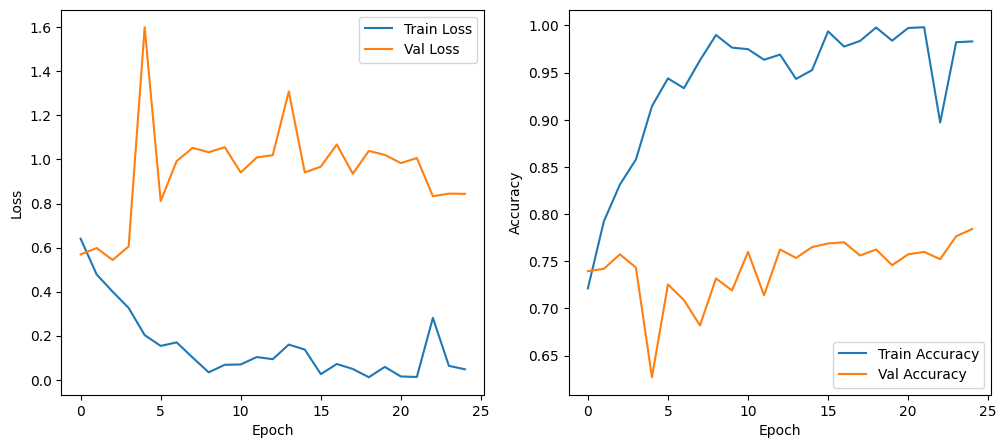

Training complete.
Best Validation Accuracy: 0.7842


In [5]:
train_model(model, train_loader, val_loader, criterion, optimizer, 'cuda', num_epochs=25)